# [COM6513] Assignment: Topic Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for topic classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**2 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**3 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**1 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500} and the dropout rate {e.g. 0.2, 0.5}. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**2 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**1 mark**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**1 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**3 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices. You must provide detailed explanations of your implementation, provide a detailed analysis of the results (e.g. why a model performs better than other models etc.) including error analyses (e.g. examples and discussion/analysis of missclasifications etc.)  (**10 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in Lab 1 (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

Class 1: Politics, Class 2: Sports, Class 3: Economy

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You **must** submit a Jupyter Notebook file (assignment_yourusername.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`, you need to have a Latex distribution installed e.g. MikTex or MacTex and pandoc). If you are unable to export the pdf via Latex, you can print the notebook web page to a pdf file from your browser (e.g. on Firefox: File->Print->Save to PDF).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results and discussion is as important as the implementation and accuracy of your models. Please be brief and consice in your discussion and analyses. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 12 Apr 2024** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



### Machine Used for the assignment
`Windows` machine was used to write and test codes 

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
df_train = pd.read_csv("./data_topic/train.csv") #training
df_dev = pd.read_csv("./data_topic/dev.csv") #development set for hyperparameter tuning
df_test = pd.read_csv("./data_topic/dev.csv") #test

print("Training data dimenshions:", df_train.shape)
print("Development data dimensions:", df_dev.shape)
print("Test data dimensions:", df_test.shape)

Training data dimenshions: (2399, 2)
Development data dimensions: (149, 2)
Test data dimensions: (149, 2)


In [3]:
print('\nTraining data samples:')
print(df_train.head())
print('\nDevelopment data samples:')
print(df_dev.head())
print('\nTest data samples:')
print(df_test.head())



Training data samples:
   1  \
0  1   
1  1   
2  1   
3  1   
4  1   

  Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to govern for the next two\years.  
0  Reuters - South Korean police used water canno...                                                                                                                                                                                      
1  Reuters - Thousands of Palestinian\prisoners i...                                                                                                                                                                                      
2  AFP - Sporadic gunfire and shelling took place...                                                                                                                                                                          

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [4]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

# Assuming the text column is the second one (index 1) in each dataframe
texts = pd.concat([df_train.iloc[:, 1], df_dev.iloc[:, 1], df_test.iloc[:, 1]]).tolist()

### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [5]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    # Tokenize the document based on the provided token_pattern
    tokens = [token for token in re.findall(token_pattern, x_raw.lower()) if token not in stop_words]
    
    # Function to generate n-grams from tokens
    def generate_ngrams(tokens, n):
        ngrams = []
        for i in range(len(tokens) - n + 1):
            ngram = ' '.join(tokens[i:i+n])
            ngrams.append(ngram)
        return ngrams
    
    # Initialize list to store all extracted n-grams
    x = []
    
    # Generate n-grams for each n in ngram_range
    for n in range(ngram_range[0], ngram_range[1] + 1):
        ngrams = generate_ngrams(tokens, n)
        # Filter by vocab if vocab is not empty
        if vocab:
            ngrams = [ngram for ngram in ngrams if ngram in vocab]
        x.extend(ngrams)
    
    return x

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [6]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    vocab = set()
    df = Counter()
    ngram_counts = Counter()
    
    for doc in X_raw:
        # Extract n-grams for each document
        ngrams = extract_ngrams(doc, ngram_range, token_pattern, stop_words)
        # Update document frequency (df) for each unique n-gram in this document
        df.update(set(ngrams))
        # Update overall n-gram counts
        ngram_counts.update(ngrams)
    
    # Filter ngrams by document frequency (min_df)
    if min_df > 0:
        df = Counter({ngram: freq for ngram, freq in df.items() if freq >= min_df})
        ngram_counts = Counter({ngram: freq for ngram, freq in ngram_counts.items() if ngram in df})
    
    # Keep only the top-N most frequent ngrams if keep_topN is specified
    if keep_topN > 0:
        vocab = set([ngram for ngram, freq in ngram_counts.most_common(keep_topN)])
    else:
        vocab = set(ngram_counts.keys())
    
    # Return only the ngrams that are in the vocab
    df = Counter({ngram: freq for ngram, freq in df.items() if ngram in vocab})
    ngram_counts = Counter({ngram: freq for ngram, freq in ngram_counts.items() if ngram in vocab})
    
    return vocab, df, ngram_counts


Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [7]:
vocab, df, ngram_counts = get_vocab(texts, 
                                    ngram_range=(1,1), 
                                    token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                                    min_df=2, 
                                    keep_topN=3000, 
                                    stop_words=stop_words)

# Display the results
print("Random 10 words from the Vocabulary (Set of Unigrams):") 
print(list(vocab)[:10])
print("\nDocument Frequencies (DF) of 10 Unigrams from the vocabulary:")
print(list(dict(df).items())[:10])
print("\nRaw Frequencies of 10 Unigrams from the vocabulary:")
print(list(dict(ngram_counts).items())[:10])

Random 10 words from the Vocabulary (Set of Unigrams):
['let', 'scandal', 'khartoum', 'darfur', 'percent', 'reached', 'owen', 'cause', 'illinois', 'toronto']

Document Frequencies (DF) of 10 Unigrams from the vocabulary:
[('send', 17), ('water', 23), ('least', 61), ('used', 20), ('south', 51), ('troops', 65), ('sunday', 161), ('seoul', 4), ('decision', 30), ('protesters', 6)]

Raw Frequencies of 10 Unigrams from the vocabulary:
[('reuters', 737), ('south', 53), ('korean', 9), ('police', 55), ('used', 20), ('water', 24), ('central', 23), ('seoul', 4), ('sunday', 163), ('least', 61)]


Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [8]:
# Create a list from vocab to ensure consistent ordering
vocab_list = sorted(list(vocab))

# Create Word -> Vocabulary ID Dictionary
word_to_id = {word: idx for idx, word in enumerate(vocab_list)}

# Create Vocabulary ID -> Word Dictionary
id_to_word = {idx: word for word, idx in word_to_id.items()}

# Display the dictionaries
print("Word -> ID Dictionary for 1st 10 words in vocabulary:")
print(list(word_to_id.items())[:10])
print("\nID -> Word Dictionary for 1st 10 words in vocabulary:")
print(list(id_to_word.items())[:10])

Word -> ID Dictionary for 1st 10 words in vocabulary:
[('abandon', 0), ('about', 1), ('above', 2), ('abroad', 3), ('ac', 4), ('accept', 5), ('accepted', 6), ('accident', 7), ('according', 8), ('account', 9)]

ID -> Word Dictionary for 1st 10 words in vocabulary:
[(0, 'abandon'), (1, 'about'), (2, 'above'), (3, 'abroad'), (4, 'ac'), (5, 'accept'), (6, 'accepted'), (7, 'accident'), (8, 'according'), (9, 'account')]


### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [9]:
train_texts = df_train.iloc[:, 1].tolist()
dev_texts = df_dev.iloc[:, 1].tolist()
test_texts = df_test.iloc[:, 1].tolist()

def docs_to_tokens(docs):
    tokens_list = []
    for doc in docs:
         # Tokenize the document
        tokens = extract_ngrams(doc, ngram_range=(1,1), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words = stop_words)
        tokens_list.append(tokens)
    
    return tokens_list

train_tokens = docs_to_tokens(train_texts)
dev_tokens = docs_to_tokens(dev_texts)
test_tokens = docs_to_tokens(test_texts)

Then convert them into lists of indices in the vocabulary:

In [10]:
def tokens_to_indices(tokens_list, word_to_id):
    token_indices = []
    for tokens in tokens_list:
        # Convert tokens to indices, filtering out tokens not in the vocabulary
        indices = [word_to_id[word] for word in tokens if word in word_to_id]
        token_indices.append(indices)
    return token_indices

# Assuming train_texts, dev_texts, and test_texts are your datasets
train_indices = tokens_to_indices(train_tokens, word_to_id)
dev_indices = tokens_to_indices(dev_tokens, word_to_id)
test_indices = tokens_to_indices(test_tokens, word_to_id)

Put the labels `Y` for train, dev and test sets into arrays: 

In [11]:
train_labels = df_train.iloc[:, 0].tolist()  # labels for the training set
dev_labels = df_dev.iloc[:, 0].tolist()  # labels for the development set
test_labels = df_test.iloc[:, 0].tolist()  # labels for the test set

# Convert label lists into NumPy arrays
Y_train = np.array(train_labels)
Y_dev = np.array(dev_labels)
Y_test = np.array(test_labels)


# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [12]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.1):
    """
    Initialize the network's weights with an option to set the initialization value.

    Parameters:
    - vocab_size: The size of the vocabulary.
    - embedding_dim: The size of the word embeddings.
    - hidden_dim: A list of the sizes of any subsequent hidden layers.
    - num_classes: The number of classes for the output layer.
    - init_val: The maximum absolute value for initializing the weights.

    Returns:
    - W: A dictionary mapping from layer index to the corresponding weight matrix.
    """
    np.random.seed(0)  # For reproducibility
    W = {}

    # Calculate the range for uniform distribution
    low, high = -init_val, init_val

    # Embedding layer weights
    W[0] = np.random.uniform(low, high, (vocab_size, embedding_dim)).astype(np.float32)

    prev_dim = embedding_dim

    # Hidden layer weights
    for i, hid_dim in enumerate(hidden_dim, start=1):
        W[i] = np.random.uniform(low, high, (prev_dim, hid_dim)).astype(np.float32)
        prev_dim = hid_dim

    # Output layer weights
    W[len(hidden_dim) + 1] = np.random.uniform(low, high, (prev_dim, num_classes)).astype(np.float32)

    return W
    

In [13]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=3)

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [14]:
def softmax(z):
    """
    Compute the softmax of array z.

    Parameters:
    - z: A numpy array of real numbers.

    Returns:
    - sig: The softmax of z.
    """
    # Ensure numerical stability by subtracting the max from z by shifting the inputs to a range where the largest value is 0
    #To avoid overflow problem
    z_shifted = z - np.max(z) 
    
    # Compute the softmax
    exp_z = np.exp(z_shifted)
    sum_exps = np.sum(exp_z)
    
    if sum_exps == 0:
        sum_exps = 1e-9
    
    sig = exp_z / sum_exps
    #print(sig)
    
    return sig

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [15]:
def categorical_loss(y, y_preds):
    # Select the predicted probability corresponding to the true class
    p = y_preds[y-1]
    # Compute the negative log of the probability
    l = -np.log(p + 1e-9)
    
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [16]:
def relu(z):
     # Ensure we do not modify the original input array
    a = z.copy()

    # Apply ReLU: max(z, 0) for each element in z
    a[a < 0] = 0

    return a
    
def relu_derivative(z):
    # Ensure we do not modify the original input array
    dz = z.copy()
    
    # Derivative is 1 for z > 0, 0 otherwise
    dz[dz <= 0] = 0
    dz[dz > 0] = 1
    
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [17]:
def dropout_mask(size, dropout_rate):
     # Create a vector of ones with the given size
    dropout_vec = np.ones(size)
    
    # Calculate the number of elements to set to zero based on the dropout rate
    num_zeros = int(size * dropout_rate)
    
    # Generate random indices to set to zero
    indices_to_zero = np.random.choice(range(size), size=num_zeros, replace=False)
    
    # Set the selected indices to zero
    dropout_vec[indices_to_zero] = 0

    return dropout_vec
    

In [18]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 0. 1. 1. 1. 1. 1. 1. 0. 1.]
[1. 1. 1. 0. 1. 1. 1. 1. 1. 0.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [19]:
def forward_pass(x, W, dropout_rate=0.2):
    out_vals = {}

    # Embedding layer: Average embeddings corresponding to input indices
    avg_embedding = np.mean(W[0][x, :], axis=0) if len(x) > 0 else np.zeros(W[0].shape[1])
    a = avg_embedding  # Initial activation from averaged embeddings

    # Lists to store layer-wise outputs
    #h_vecs = [np.zeros(W[0].shape[1])]  # Zero vector for embedding layer pre-activation
    h_vecs = [np.sum(W[0][x, :], axis=0) if len(x) > 0 else np.zeros(W[0].shape[1])]
    a_vecs = [avg_embedding]  # First activation is the averaged embedding
    dropout_vecs = []  # Store dropout masks applied after each hidden layer

    # Process hidden layers
    for i in range(1, len(W) - 1):
        h = np.dot(a, W[i])  # Compute pre-activation for current layer
        a = relu(h)  # Apply ReLU activation function
        dropout_vec = dropout_mask(a.shape[0], dropout_rate)  # Generate dropout mask
        a = a * dropout_vec  # Apply dropout mask to activations
        # Store outputs
        h_vecs.append(h)
        a_vecs.append(a)
        dropout_vecs.append(dropout_vec)
        
    # Output layer
    final_h = np.dot(a, W[len(W)-1])  # Pre-activation for output layer
    prediction = softmax(final_h)  # Apply softmax to get class probabilities

    # Compile outputs
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout_vecs'] = dropout_vecs
    out_vals['prediction'] = prediction
    
    return out_vals
    

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [20]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    grads = {}
    num_layers = len(W) + 1
    
    # Output layer error (prediction - one-hot encoded true label)
    d_out = out_vals['prediction'].copy()
    d_out[y-1] -= 1 #derivative of loss wrt pre-activation value towards output layer 
    
    # Loop through layers in reverse order to backpropagate the error
    for i in range(num_layers - 2, 0, -1):
        # Compute gradients for weights (dW)
        if i == num_layers - 2:
            grads[i] = np.outer(out_vals['a'][i-1], d_out) #derivative of loss wrt weights for output layer
            d_prev = np.dot(d_out, W[i].T)
        else:
            # Apply derivative of activation function (ReLU in this case)
            d_prev = d_prev * relu_derivative(out_vals['h'][i]) #derivative of loss wrt pre-activation value towards hidden layer 
            grads[i] = np.outer(out_vals['a'][i-1], d_prev) #derivative of loss wrt weights for hidden layer
            d_prev = np.dot(d_prev, W[i].T) #derivative of loss wrt activation value as hidden layer output
        
        # Update weights
        W[i] -= lr * grads[i] #Applying Gradien descent for updating weight matrices
    
    # Update embedding weights, if not frozen
    if not freeze_emb:
        for idx in x:
            # Example fix, adjust based on actual intent and structure of d_prev
            W[0][idx, :] -= lr * d_prev / len(x)  # Assuming d_prev is to be applied uniformly

    
    return W


Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [21]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []

    for epoch in range(epochs):
        train_loss = 0
        for x, y in zip(X_tr, Y_tr):
            # Forward pass
            out_vals = forward_pass(x, W, dropout)
            # Calculate loss (assuming categorical_loss is implemented)
            loss = categorical_loss(y, out_vals['prediction'])
            train_loss += loss
            # Backward pass
            W = backward_pass(x, y, W, out_vals, lr, freeze_emb)
        
        # Average training loss for the epoch
        avg_train_loss = train_loss / len(X_tr)
        training_loss_history.append(avg_train_loss)

        # Validation
        if X_dev and Y_dev.any():
            validation_loss = 0
            for x, y in zip(X_dev, Y_dev):
                out_vals = forward_pass(x, W, dropout)
                loss = categorical_loss(y, out_vals['prediction'])
                validation_loss += loss
            avg_validation_loss = validation_loss / len(X_dev)
            validation_loss_history.append(avg_validation_loss)
            
            # Early stopping
            if epoch > 0 and (validation_loss_history[-2] - avg_validation_loss) < tolerance:
                print("Early stopping triggered.")
                break
        
        # Print progress
        if print_progress:
            print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_validation_loss:.4f}")
    

    
    
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [22]:
learning_rates = [1e-3,5e-3,8e-3]
epochs = [100,200]
val_loss = float('inf')

model = {}
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[], num_classes=3)
for i in range(len(W)):
            print('Shape W'+str(i), W[i].shape)


for lr in learning_rates:
    for epoch in epochs:
        W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[], num_classes=3)
        
        print(f'Using parameters, learning rate = {lr} and epochs = {epoch}')

        W, loss_tr, dev_loss = SGD(X_tr = train_indices, Y_tr = Y_train,
                                    W = W,
                                    X_dev=dev_indices, 
                                    Y_dev=Y_dev,
                                    lr= lr, 
                                    dropout=None,   #Dropout set to None as it does not affect the architecture in this model
                                    freeze_emb=False,
                                    tolerance=1e-5,
                                    epochs=epoch,
                                    print_progress=False)
        
        print('Current lowest validation loss: ', val_loss)
        print('Validation loss: ',dev_loss[-1])
        
        if dev_loss[-1] < val_loss:
            val_loss = dev_loss[-1]
            model['loss'] = val_loss
            model['W'] = W
            model['epochs'] = epoch
            model['learning_rate'] = lr
            model['dev_loss'] = dev_loss
            model['loss_tr'] = loss_tr

print(f'Best model hyperparmeters, learning rate = {model["learning_rate"]}, epochs = {model["epochs"]} and validation loss = {model["loss"]}')

Shape W0 (3000, 300)
Shape W1 (300, 3)
Using parameters, learning rate = 0.001 and epochs = 100
Current lowest validation loss:  inf
Validation loss:  0.7132776681453984
Using parameters, learning rate = 0.001 and epochs = 200
Current lowest validation loss:  0.7132776681453984
Validation loss:  0.38773802700913546
Using parameters, learning rate = 0.005 and epochs = 100
Current lowest validation loss:  0.38773802700913546
Validation loss:  0.2592022981611545
Using parameters, learning rate = 0.005 and epochs = 200
Early stopping triggered.
Current lowest validation loss:  0.2592022981611545
Validation loss:  0.2416315772451524
Using parameters, learning rate = 0.008 and epochs = 100
Current lowest validation loss:  0.2416315772451524
Validation loss:  0.2419789031289795
Using parameters, learning rate = 0.008 and epochs = 200
Early stopping triggered.
Current lowest validation loss:  0.2416315772451524
Validation loss:  0.24032607421570057
Best model hyperparmeters, learning rate = 0.

Plot the learning process:

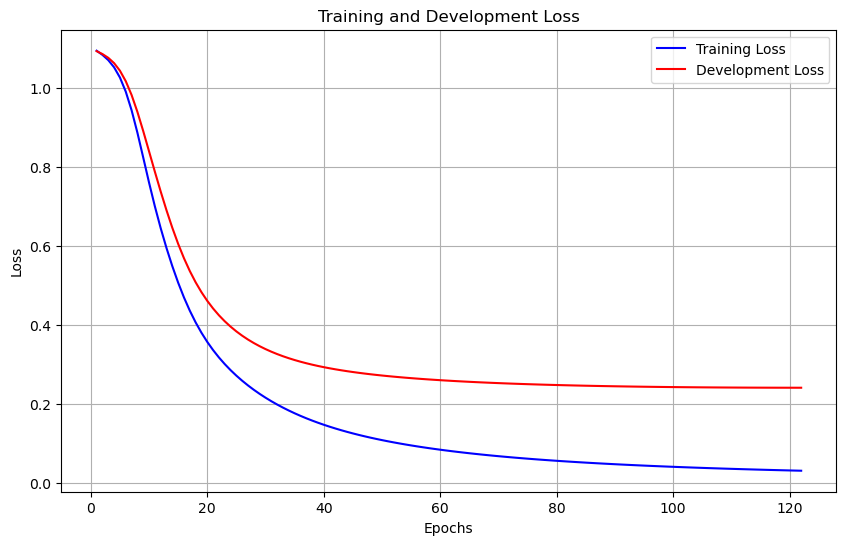

In [23]:
import matplotlib.pyplot as plt

# Assuming training_loss_history and validation_loss_history are populated
epochs = range(1, len(model['loss_tr']) + 1)

plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(epochs, model['loss_tr'], 'b-', label='Training Loss')
plt.plot(epochs, model['dev_loss'], 'r-', label='Development Loss')
plt.title('Training and Development Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

Compute accuracy, precision, recall and F1-Score:

In [24]:
preds_te = [np.argmax(forward_pass(x, model['W'], dropout_rate=0.0)['prediction']) 
            for x,y in zip(test_indices,Y_test)]

preds_te1 = []

for i in preds_te:
    preds_te1.append(i+1)


print('Accuracy:', accuracy_score(Y_test,preds_te1))
print('Precision:', precision_score(Y_test,preds_te1,average='macro'))
print('Recall:', recall_score(Y_test,preds_te1,average='macro'))
print('F1-Score:', f1_score(Y_test,preds_te1,average='macro'))

Accuracy: 0.9060402684563759
Precision: 0.9082924168030551
Recall: 0.9059863945578231
F1-Score: 0.9065802456534313


### Discuss how did you choose model hyperparameters ? 

The process for determining the hyperparameter combinations is outlined as follows:

1. **Defining Hyperparameters**: Learning rates and epochs were specified as `[1e-3, 5e-3, 8e-3]` and `[100, 200]`, respectively, aiming for a balance between learning efficiency and convergence. 
   - The selection of learning rates considers the trade-off between faster rates, which risk overshooting minima, and slower rates, which may lead to prolonged convergence.
   - Epochs, representing the dataset passes, balance underfitting with fewer epochs and potential overfitting with more, mitigated by `early stopping` based on tolerance between validation loss progress in case validation loss does not improve by a minimum of the tolerance value.

2. **Initialization**: `val_loss` was set to infinity, and an empty dictionary, `model`, was created to store the best hyperparameter configurations based on validation loss.

3. **Exploring Combinations**: Nested loops iterated through each learning rate and epoch combination. For each:
   - Weights were initialized using `network_weights()`.
   - Training occurred via Stochastic Gradient Descent (SGD), encompassing forward and backward passes and calculation of categorical loss.
   - The average validation loss was evaluated post-training per epoch, alongside average training loss for performance analysis.

4. **Evaluating Performance**: If a configuration resulted in lower validation loss than previously recorded, `val_loss` was updated, and the configuration stored in `model`.

5. **Selecting Optimal Configuration**: After testing all combinations, the configuration with the lowest validation loss was identified as optimal, with its parameters displayed.

This approach guarantees a comprehensive examination of hyperparameter influences, enhancing model performance via methodical testing and refinements. The best hyperparameters identified were `learning rate = 0.008` and `epochs = 200`.

The table for validation losses for each hyperparameter combination is given below:

| Learning Rate | Epochs | Validation Loss     |
|---------------|--------|---------------------|
| 0.001         | 100    | 0.7132776681453984  |
| 0.001         | 200    | 0.38773802700913546 |
| 0.005         | 100    | 0.2592022981611545  |
| 0.005         | 200    | 0.2416315772451524  |
| 0.008         | 100    | 0.2419789031289795  |
| 0.008         | 200    | 0.24032607421570057 |

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [25]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [26]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word_to_id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [47]:
learning_rates = [1e-5,5e-5,8e-5]
epochs = [300,400]
val_loss = float('inf')

model = {}
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[], num_classes=3)
for i in range(len(W)):
            print('Shape W'+str(i), W[i].shape)


for lr in learning_rates:
    for epoch in epochs:
        W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[], num_classes=3)
        
        W[0] = w_glove
        
        print(f'Using parameters, learning rate = {lr} and epochs = {epoch}')

        W, loss_tr, dev_loss = SGD(X_tr = train_indices, Y_tr = Y_train,
                                    W = W,
                                    X_dev=dev_indices, 
                                    Y_dev=Y_dev,
                                    lr= lr, 
                                    dropout=None,   #Dropout set to None as it does not affect the architecture in this model
                                    freeze_emb=True,
                                    tolerance=1e-3,
                                    epochs=epoch,
                                    print_progress=False)
        
        print('Current lowest validation loss: ', val_loss)
        print('Validation loss: ',dev_loss[-1])
        
        if dev_loss[-1] < val_loss:
            val_loss = dev_loss[-1]
            model['loss'] = val_loss
            model['W'] = W
            model['epochs'] = epoch
            model['learning_rate'] = lr
            model['dev_loss'] = dev_loss
            model['loss_tr'] = loss_tr


print(f'Best model hyperparmeters, learning rate = {model["learning_rate"]}, epochs = {model["epochs"]} and validation loss = {model["loss"]}')

Shape W0 (3000, 300)
Shape W1 (300, 3)
Using parameters, learning rate = 1e-05 and epochs = 300
Early stopping triggered.
Current lowest validation loss:  inf
Validation loss:  0.5883742153005599
Using parameters, learning rate = 1e-05 and epochs = 400
Early stopping triggered.
Current lowest validation loss:  0.5883742153005599
Validation loss:  0.5883742153005599
Using parameters, learning rate = 5e-05 and epochs = 300
Early stopping triggered.
Current lowest validation loss:  0.5883742153005599
Validation loss:  0.37430071738665
Using parameters, learning rate = 5e-05 and epochs = 400
Early stopping triggered.
Current lowest validation loss:  0.37430071738665
Validation loss:  0.37430071738665
Using parameters, learning rate = 8e-05 and epochs = 300
Early stopping triggered.
Current lowest validation loss:  0.37430071738665
Validation loss:  0.33719937221397417
Using parameters, learning rate = 8e-05 and epochs = 400
Early stopping triggered.
Current lowest validation loss:  0.33719

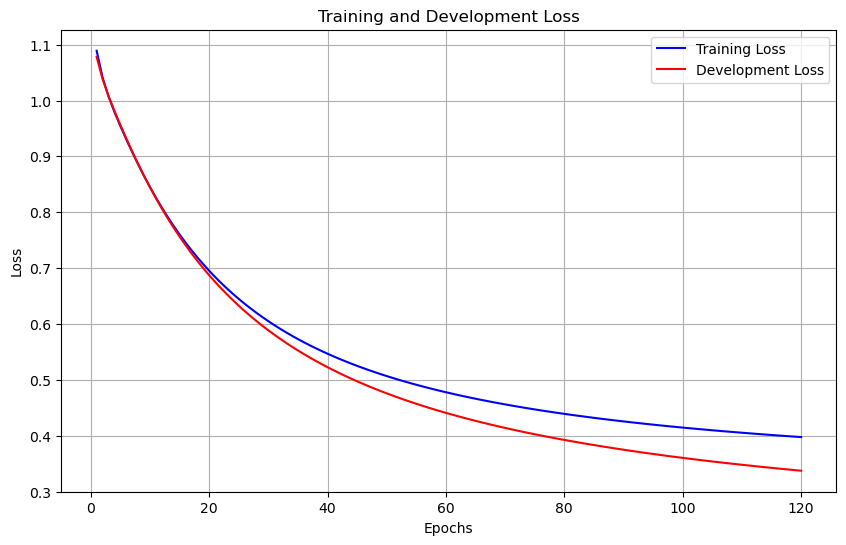

In [48]:
import matplotlib.pyplot as plt

# Assuming training_loss_history and validation_loss_history are populated
epochs = range(1, len(model['loss_tr']) + 1)

plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(epochs, model['loss_tr'], 'b-', label='Training Loss')
plt.plot(epochs, model['dev_loss'], 'r-', label='Development Loss')
plt.title('Training and Development Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

In [49]:
preds_te = [np.argmax(forward_pass(x, model['W'], dropout_rate=0.0)['prediction']) 
            for x,y in zip(test_indices,Y_test)]

preds_te1 = []

for i in preds_te:
    preds_te1.append(i+1)


print('Accuracy:', accuracy_score(Y_test,preds_te1))
print('Precision:', precision_score(Y_test,preds_te1,average='macro'))
print('Recall:', recall_score(Y_test,preds_te1,average='macro'))
print('F1-Score:', f1_score(Y_test,preds_te1,average='macro'))

Accuracy: 0.9194630872483222
Precision: 0.9231463571889104
Recall: 0.9191836734693877
F1-Score: 0.9200478645066273


### Discuss how did you choose model hyperparameters ? 

The approach to determining hyperparameter combinations is structured as follows:

#### Hyperparameter Grid:
- **Learning Rates**: Three values, `[1e-5, 5e-5, 8e-5]`, were chosen to fine-tune the model's responsiveness to subtle changes. Lower rates prioritize stable convergence, while higher rates aim for faster convergence, although potentially introducing instability.
- **Epochs**: Two values, `[300, 400]`, were selected to explore extended training durations, allowing for deeper learning and weight refinement. This enhances learning potential but raises the risk of overfitting, mitigated by an early stopping condition in case validation loss does not improve by a minimum of tolerance value.

#### Model Setup and Configuration:
- **Initial Setup**: The model initializes with `val_loss` set to infinity for easy progress tracking. The initial layer's weights are fixed with GloVe embeddings to leverage prior learning and ensure stable initial training.

#### Iterative Training and Evaluation:
- **Training**: Each hyperparameter combination undergoes training via Stochastic Gradient Descent (SGD), with an `early stopping` mechanism in place. The `freeze_emb` parameter remains `True` to preserve initial layer weights.
- **Evaluation**: Following training, average validation loss is compared with the lowest recorded loss. Any improvements prompt an update to the model configuration, adjusting the best validation loss and storing hyperparameters in the `model` dictionary.

#### Optimal Parameter Selection:
- After exploring all combinations, those yielding the lowest validation loss are identified as optimal. This encompasses specific learning rates and epoch counts.

This meticulous grid search methodology systematically examines how different settings influence model performance, favoring configurations associated with minimal validation loss. Despite its computational intensity, it's valued for its thoroughness in optimizing model performance. The best hyperparameter configuration obtained are `learning rate = 8e-5` and `epochs = 300`.

The table for validation losses for each hyperparameter combination:

| Learning Rate | Epochs | Validation Loss     |
|---------------|--------|---------------------|
| 1e-05         | 300    | 0.5883742153005599  |
| 1e-05         | 400    | 0.5883742153005599  |
| 5e-05         | 300    | 0.37430071738665    |
| 5e-05         | 400    | 0.37430071738665    |
| 8e-05         | 300    | 0.33719937221397417 |
| 8e-05         | 400    | 0.33719937221397417 |

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [50]:
learning_rates = [1e-6,2e-5,5e-5]
epochs = [300,400]
dr = [0.009,0.4]
hd = [[100],[300]]
val_loss = float('inf')

model = {}


for lr in learning_rates:
    for epoch in epochs:
        for dropout in dr:
              for hid_dim in hd:
                W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                            hidden_dim=hid_dim, num_classes=3)
                
                for i in range(len(W)):
                    print('Shape W'+str(i), W[i].shape)
                
                W[0] = w_glove
                
                print(f'Using parameters, learning rate = {lr}, epochs = {epoch}, dropout rate = {dropout} and hidden dimensions = {hid_dim}')

                W, loss_tr, dev_loss = SGD(X_tr = train_indices, Y_tr = Y_train,
                                            W = W,
                                            X_dev=dev_indices, 
                                            Y_dev=Y_dev,
                                            lr= lr, 
                                            dropout=dropout,
                                            freeze_emb=True,
                                            tolerance=1e-7,
                                            epochs=epoch,
                                            print_progress=False)
                
                print('Current lowest validation loss: ', val_loss)
                print('Validation loss: ',dev_loss[-1])
                
                if dev_loss[-1] < val_loss:
                    val_loss = dev_loss[-1]
                    model['loss'] = val_loss
                    model['W'] = W
                    model['epochs'] = epoch
                    model['learning_rate'] = lr
                    model['dev_loss'] = dev_loss
                    model['loss_tr'] = loss_tr
                    model['hid_dim'] = hid_dim
                    model['dropout'] = dropout

print(f'Best model hyperparmeters, learning rate = {model["learning_rate"]}, epochs = {model["epochs"]}, hidden dimensions = {model["hid_dim"]}, dropout rate = {model["dropout"]} and validation loss = {model["loss"]}')


Shape W0 (3000, 300)
Shape W1 (300, 100)
Shape W2 (100, 3)
Using parameters, learning rate = 1e-06, epochs = 300, dropout rate = 0.009 and hidden dimensions = [100]
Current lowest validation loss:  inf
Validation loss:  1.060878366996014
Shape W0 (3000, 300)
Shape W1 (300, 300)
Shape W2 (300, 3)
Using parameters, learning rate = 1e-06, epochs = 300, dropout rate = 0.009 and hidden dimensions = [300]
Early stopping triggered.
Current lowest validation loss:  1.060878366996014
Validation loss:  1.094861345920171
Shape W0 (3000, 300)
Shape W1 (300, 100)
Shape W2 (100, 3)
Using parameters, learning rate = 1e-06, epochs = 300, dropout rate = 0.4 and hidden dimensions = [100]
Early stopping triggered.
Current lowest validation loss:  1.060878366996014
Validation loss:  1.0993407592776276
Shape W0 (3000, 300)
Shape W1 (300, 300)
Shape W2 (300, 3)
Using parameters, learning rate = 1e-06, epochs = 300, dropout rate = 0.4 and hidden dimensions = [300]
Early stopping triggered.
Current lowest val

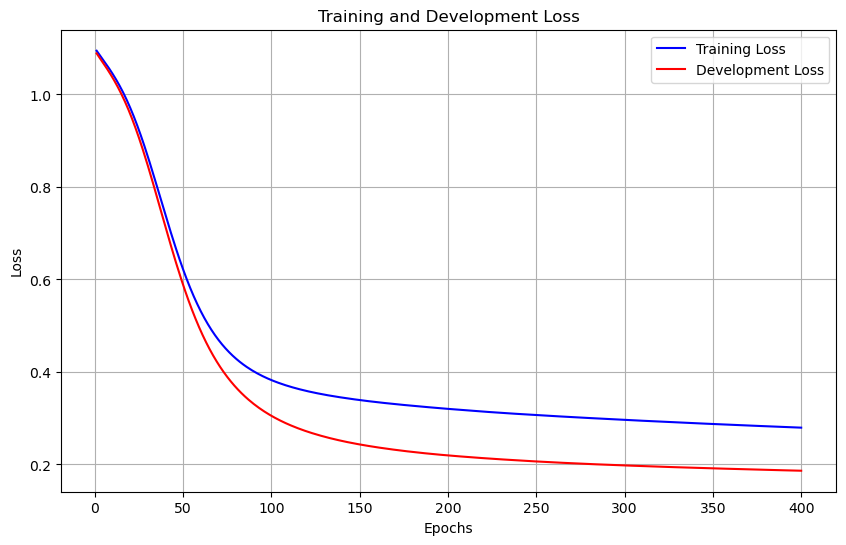

In [51]:
import matplotlib.pyplot as plt

# Assuming training_loss_history and validation_loss_history are populated
epochs = range(1, len(model['loss_tr']) + 1)

plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(epochs, model['loss_tr'], 'b-', label='Training Loss')
plt.plot(epochs, model['dev_loss'], 'r-', label='Development Loss')
plt.title('Training and Development Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

In [52]:
preds_te = [np.argmax(forward_pass(x, model['W'], dropout_rate=0.0)['prediction'])
            for x,y in zip(test_indices,Y_test)]

preds_te1 = []

for i in preds_te:
    preds_te1.append(i+1)


print('Accuracy:', accuracy_score(Y_test,preds_te1))
print('Precision:', precision_score(Y_test,preds_te1,average='macro', zero_division=0))
print('Recall:', recall_score(Y_test,preds_te1,average='macro'))
print('F1-Score:', f1_score(Y_test,preds_te1,average='macro'))

Accuracy: 0.9395973154362416
Precision: 0.9407756813417191
Recall: 0.9393197278911565
F1-Score: 0.9396157221771704


### Discuss how did you choose model hyperparameters ? 

The selection of model hyperparameters was conducted using a grid search method, which thoroughly tested combinations of learning rates, epochs, dropout rates, and hidden layer dimensions to determine the optimal settings that minimize validation loss.

#### Hyperparameter Grid:
- **Learning Rates** (`[1e-6, 2e-5, 5e-5]`): Selected to explore the balance between fast learning (higher rates) and stable convergence (lower rates) alongside fine-tuning the model's responsiveness to subtle changes.
- **Epochs** (`[300, 400]`): Assessed to evaluate the influence of training duration on model performance, with longer training potentially leading to overfitting, mitigated by early stopping based on validation loss improvements.
- **Dropout Rates** (`[0.009, 0.4]`): Examined to determine the right level of regularization needed to prevent overfitting without causing underfitting due to excessive neuron deactivation which may cause higher validation loss and thus lesser accuracy.
- **Hidden Dimensions** (`[[100], [300]]`): Tested to identify the most effective network complexity for pattern recognition.

#### Process:
1. **Initialization**: Model weights were initialized, setting the first layer to GloVe embeddings (frozen to retain pre-trained features).
2. **Iterative Training**: Each parameter set was trained using Stochastic Gradient Descent (SGD), with close monitoring of progress.
3. **Performance Evaluation**: Validation loss was recorded for each setup. If a setup achieved a lower validation loss than previously seen, it was recorded as the best configuration.

#### Outcome:
The best configuration featured a learning rate of `5e-5`, `400` epochs, a dropout rate of `0.009`, and hidden dimensions of `[100]`, achieving the lowest validation loss of `0.1863730005664646`. This method ensured a data-driven determination of hyperparameters, optimizing model performance effectively. The lower dropout rate proved more appropriate, indicating that higher rates were leading to underfitting.

The table for validation losses for each hyperparameter combination given below:


| Learning Rate | Epochs | Dropout Rate | Hidden Dimensions | Validation Loss     |
|---------------|--------|--------------|-------------------|---------------------|
| 1e-06         | 300    | 0.009        | [100]             | 1.060878366996014   |
| 1e-06         | 300    | 0.009        | [300]             | 1.094861345920171   |
| 1e-06         | 300    | 0.4          | [100]             | 1.0993407592776276  |
| 1e-06         | 300    | 0.4          | [300]             | 1.1011493863828534  |
| 1e-06         | 400    | 0.009        | [100]             | 1.0491016540311457  |
| 1e-06         | 400    | 0.009        | [300]             | 1.094861345920171   |
| 1e-06         | 400    | 0.4          | [100]             | 1.0993407592776276  |
| 1e-06         | 400    | 0.4          | [300]             | 1.1011493863828534  |
| 2e-05         | 300    | 0.009        | [100]             | 0.27039444171872007 |
| 2e-05         | 300    | 0.009        | [300]             | 0.39393502240205436 |
| 2e-05         | 300    | 0.4          | [100]             | 1.0961437724958372  |
| 2e-05         | 300    | 0.4          | [300]             | 1.0891813760287834  |
| 2e-05         | 400    | 0.009        | [100]             | 0.2367237532784828  |
| 2e-05         | 400    | 0.009        | [300]             | 0.39393502240205436 |
| 2e-05         | 400    | 0.4          | [100]             | 1.0961437724958372  |
| 2e-05         | 400    | 0.4          | [300]             | 1.0705038041835337  |
| 5e-05         | 300    | 0.009        | [100]             | 0.19784047474683744 |
| 5e-05         | 300    | 0.009        | [300]             | 0.32767017843736734 |
| 5e-05         | 300    | 0.4          | [100]             | 1.091128271065582   |
| 5e-05         | 300    | 0.4          | [300]             | 1.0705038041835337  |
| 5e-05         | 400    | 0.009        | [100]             | 0.1863730005664646  |
| 5e-05         | 400    | 0.009        | [300]             | 0.32767017843736734 |
| 5e-05         | 400    | 0.4          | [100]             | 1.091128271065582   |
| 5e-05         | 400    | 0.4          | [300]             | 1.0705038041835337  |

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |  90.8% |  90.6% |  90.7% |  90.6%|
| Average Embedding (Pre-trained)  |  92.3% |  91.9% |  92% |  91.9% |
| Average Embedding (Pre-trained) + X hidden layers    | 94%  |  93.9% | 93.9%  |  93.9% |


Please discuss why your best performing model is better than the rest and provide a bried error analaysis.

## Discussion:

### Models Comparison:
1. **Average Embedding**: This basic model uses average embeddings possibly trained from scratch. It provides decent results but lacks the depth of semantic understanding and contextualization that pre-trained models offer.

2. **Average Embedding (Pre-trained)**: Leveraging pre-trained embeddings significantly improves performance across all metrics. Pre-trained models like Word2Vec or GloVe are trained on vast corpora, capturing rich semantic relationships between words. This enhancement likely provides a better foundational representation of text, leading to improved classification accuracy.

3. **Average Embedding (Pre-trained) + X hidden layers**: Adding hidden layers to the model with pre-trained embeddings further enhances its ability to learn non-linear relationships and complex patterns in the data. The increase in all performance metrics indicates that the additional layers enable the model to capture more abstract features of the data, which are crucial for tasks such as text classification or sentiment analysis.

The top-performing model, "Average Embedding (Pre-trained) + X hidden layers," excels because it uses GloVe's pre-trained word embeddings along with additional hidden layers. This combination enhances the model's understanding of language and its ability to recognize complex patterns.

### Model Performance Analysis:
1. **Pre-trained Embeddings**: The model utilizes GloVe embeddings, which are advanced vector representations of words created by Stanford researchers. These embeddings provide a deep understanding of language nuances not typically captured in smaller, specialized datasets. This strong linguistic foundation improves the model's ability to accurately analyze and predict text.

2. **Additional Hidden Layers**: Adding layers to the model allows it to uncover and interpret complex and abstract relationships within the data. These layers enable the model to connect different data features, helping it identify detailed patterns that simpler models might miss. This feature is particularly useful for tasks requiring detailed language processing or dealing with complex datasets.

### Error Analysis:
The model can still be improved considering the errors below:

1. **Data Imbalances and Bias**: If the training data favors certain categories over others, the model might develop a bias toward the more common categories. This leads to poorer performance on rarer categories due to insufficient training on these types.

2. **Overfitting**: More layers can make the model overly complex, causing it to learn irrelevant features from the training data. This can harm its ability to generalize well to new data.

3. **Limitations of Embeddings**: While GloVe embeddings offer a strong base, they are based on generalised texts and lack specific terms used in specialized fields like medicine or law, which can limit the model's performance with respect to those terms.

4. **Polysemy Issue (Multiple Meanings)**: Many words in the general language can have multiple meanings. For example, the word `bank` can mean either a financial institution or the side of a river. Without providing the right context, these words might be misunderstood by the network model.